# Proof-of-Concept: IMM-inspired synthetic energy module design (Complex I + AOX + F1Fo ATP synthase)
### with simulated build records, ML surrogate modeling, interpretability, robustness, and design proposals.
The ability to build ATP-generating proteomembrane assemblies has been demonstrated repeatedly in landmark reconstitutions, from light-driven bacteriorhodopsin–ATP synthase vesicles to respiration-mimicking NADH-driven minimal systems (Steinberg-Yfrach et al., 1998; Berhanu et al., 2019; von Ballmoos et al., 2016; Biner et al., 2020). Yet the field remains constrained by an engineering bottleneck, robust, scalable, and data-efficient iteration is rarely achieved because build records, QC gates, and structured decision-making are inconsistently implemented. This script contributes a transferable engineering operating system for this space, a manufacturing-style DBTL discipline that formalizes (i) build-record schemas, (ii) QC gating and release labels, (iii) interpretable surrogate modelling with uncertainty proxies, (iv) robustness maps identifying stable operating envelopes, and (v) algorithmic next-build proposals for closed-loop iteration.
## Real-world numeric anchors (journal-indexed) used to set simulation magnitudes:
### 1) Berhanu, Ueda, Kuruma (2019) Nature Communications:
    - 4.6 µmol ATP per mg ATP synthase after 6 h illumination (inside GUV), and
    - initial reaction rate reported ~223 ± 6.1 ATP nmol min−1 mg−1 (Fig. 1d text).
    (Berhanu et al., 2019)

### 2) Biner, Fedor, Yin, Hirst (2020) ACS Synthetic Biology (PMC):
    - NADH-driven ATP synthesis assay initiated with 200 µM NADH and uses 0.2 µM ATP as internal standard,
    - kcat ~29 ATP s−1 for Ec-F1Fo in their optimized system,
    - best lipid mix ~10% CL : 10% DOPE : 80% DOPC (w/w),
    - storage decay ~50% activity at 9 days, ~10% at 15 days at 4°C.
    (Biner et al., 2020)

 These are used only to set plausible ranges, not to claim exact replication of any one experimental setup.

In [28]:
from __future__ import annotations
import os, json, math, time
from dataclasses import dataclass, asdict
from typing import Any, Dict, List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# 0) Repro + output options

In [31]:
SEED = 7
rng = np.random.default_rng(SEED)

# If you want files saved, set SAVE_FILES=True. Figures will still display inline regardless.
SAVE_FILES = False
OUTDIR = "imm_energy_outputs"
FIGDIR = os.path.join(OUTDIR, "figures")
TABDIR = os.path.join(OUTDIR, "tables")
DATADIR = os.path.join(OUTDIR, "data")
RECDIR = os.path.join(OUTDIR, "build_records")

if SAVE_FILES:
    for d in [OUTDIR, FIGDIR, TABDIR, DATADIR, RECDIR]:
        os.makedirs(d, exist_ok=True)

plt.rcParams.update({
    "figure.dpi": 140,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

# 1) Helpers

In [34]:
def clamp(x, lo, hi):
    return np.minimum(np.maximum(x, lo), hi)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def lognormal_from_mean_cv(mean: float, cv: float, size: int = 1) -> np.ndarray:
    # For lognormal: CV^2 = exp(s^2)-1 => s^2 = ln(CV^2+1); mu = ln(mean) - 0.5*s^2
    s2 = math.log(cv * cv + 1.0)
    s = math.sqrt(s2)
    mu = math.log(mean) - 0.5 * s2
    return rng.lognormal(mean=mu, sigma=s, size=size)

def exp_decay_k_from_half_life_days(t_half_days: float) -> float:
    return math.log(2.0) / t_half_days

def ensure_json_serializable(obj: Any) -> Any:
    if isinstance(obj, (np.integer,)):
        return int(obj)
    if isinstance(obj, (np.floating,)):
        return float(obj)
    if isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    if isinstance(obj, dict):
        return {k: ensure_json_serializable(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [ensure_json_serializable(x) for x in obj]
    return obj

def maybe_save_table(df: pd.DataFrame, name: str) -> None:
    if SAVE_FILES:
        df.to_csv(os.path.join(TABDIR, f"{name}.csv"), index=False)

def maybe_save_build_json(rec: dict, build_id: str) -> None:
    if SAVE_FILES:
        with open(os.path.join(RECDIR, f"{build_id}.json"), "w", encoding="utf-8") as f:
            json.dump(ensure_json_serializable(rec), f, indent=2)

# Storage decay anchor: ~50% activity at 9 days (Biner et al., 2020)

K_DECAY_PER_DAY = exp_decay_k_from_half_life_days(9.0)

# 2) Build record schema

In [37]:
@dataclass
class IMMBuildRecord:
    build_id: str
    schema_version: str
    sop_version: str
    date_time_utc: str
    operator_id: str
    lab_site: str

    # Operating mode: IMM-like respiration module vs light module vs none
    mode: str  # NADH | LIGHT | NONE

    # Platform: full vesicle vs IMM patch (planar supported bilayer / nanodisc-like surrogate)
    platform: str  # vesicle | patch
    membrane_material: str  # lipid | polymersome

    # Lipids (w/w fractions)
    lipid_CL_frac: float
    lipid_DOPE_frac: float
    lipid_DOPC_frac: float
    cholesterol_frac: float

    # Core stoichiometries (dimensionless proxies)
    atpsyn_to_lipid_ratio: float
    ci_to_atpsyn_molar_ratio: float
    aox_to_ci_molar_ratio: float
    q10_nmol_mg_lipid: float

    # Assembly variables
    assembly_method: str  # detergent_removal | microfluidic_mix | film_hydration
    detergent_type: str  # DDM | OG | CHAPS
    detergent_conc_mM: float
    detergent_removal_method: str  # biobeads | dialysis | dilution
    temp_C: float
    mixing_rpm: float
    assembly_duration_min: float

    # Orientation control (explicitly normalized probabilities, fixes earlier error)
    orientation_method: str  # none | affinity | asymmetric_support | gradient_insertion

    # QC/structure observables (measured after build)
    visible_aggregation: str  # none | mild | severe
    size_mean_nm: float
    size_pdi: float
    encapsulation_leak_rate_pct_per_h: float

    # Protein module observables (measured after build)
    protein_incorporation_fraction: float
    orientation_proxy_score: float
    pmf_proxy_AU: float
    on_off_ratio: float

    # Functional outputs
    atp_rate_uM_per_min: float
    atp_yield_30min_uM: float
    nadh_consumption_uM_per_min: float
    activity_after_storage_day9_frac: float

    # QC flags
    QC_BACKGROUND_OK: bool
    QC_SIZE_OK: bool
    QC_LEAK_OK: bool
    QC_ONOFF_OK: bool
    qc_status: str  # PASS | CONDITIONAL_PASS | FAIL

# 3) Simulation model

In [40]:
def simulate_single_build(i: int) -> IMMBuildRecord:
    build_id = f"IMM-{i:05d}"

    # Choose mode and platform
    mode = rng.choice(["NADH", "LIGHT", "NONE"], p=[0.55, 0.35, 0.10])
    platform = rng.choice(["vesicle", "patch"], p=[0.75, 0.25])
    membrane_material = rng.choice(["lipid", "polymersome"], p=[0.80, 0.20])

    # Lipids: encourage IMM-like CL and PE fractions, but allow exploration
    # Biner et al., 2020 optimized at ~10% CL, 10% DOPE, 80% DOPC (w/w)
    lipid_CL = float(clamp(rng.normal(0.11, 0.05), 0.00, 0.25))
    lipid_DOPE = float(clamp(rng.normal(0.12, 0.06), 0.00, 0.30))
    cholesterol = float(clamp(rng.normal(0.04, 0.04), 0.00, 0.20))

    lipid_DOPC = float(clamp(1.0 - (lipid_CL + lipid_DOPE + cholesterol), 0.20, 1.0))
    s = lipid_CL + lipid_DOPE + lipid_DOPC
    lipid_CL /= s
    lipid_DOPE /= s
    lipid_DOPC /= s

    # Stoichiometries / loadings (dimensionless proxies)
    atpsyn_to_lipid_ratio = float(clamp(lognormal_from_mean_cv(0.006, 0.8)[0], 0.0003, 0.05))

    if mode == "NADH":
        ci_to_atpsyn = float(clamp(lognormal_from_mean_cv(1.0, 0.75)[0], 0.05, 10.0))
        aox_to_ci = float(clamp(lognormal_from_mean_cv(0.6, 0.8)[0], 0.01, 8.0))
        q10 = float(clamp(rng.normal(10.0, 5.0), 0.0, 25.0))  # nmol/mg lipid, Biner reports kinetic dependence
    else:
        ci_to_atpsyn, aox_to_ci, q10 = 0.0, 0.0, 0.0

    # Assembly knobs
    assembly_method = rng.choice(["detergent_removal", "microfluidic_mix", "film_hydration"], p=[0.60, 0.20, 0.20])
    detergent_type = rng.choice(["DDM", "OG", "CHAPS"], p=[0.60, 0.30, 0.10])
    detergent_conc_mM = float(clamp(lognormal_from_mean_cv(1.4, 0.9)[0], 0.05, 12.0))
    detergent_removal_method = rng.choice(["biobeads", "dialysis", "dilution"], p=[0.55, 0.35, 0.10])
    temp_C = float(clamp(rng.normal(22, 4), 4, 37))
    mixing_rpm = float(clamp(rng.normal(850, 280), 0, 2000))
    assembly_duration_min = float(clamp(lognormal_from_mean_cv(180, 0.7)[0], 10, 1500))

    # Orientation control, ensure probabilities sum to 1 (fixes your earlier ValueError)
    # Patches support "asymmetric_support" better than vesicles.
    if platform == "patch":
        p = np.array([0.35, 0.35, 0.15, 0.15], dtype=float)
    else:
        p = np.array([0.45, 0.35, 0.05, 0.15], dtype=float)
    p = p / p.sum()
    orientation_method = rng.choice(["none", "affinity", "asymmetric_support", "gradient_insertion"], p=p)

    # Aggregation
    visible_aggregation = rng.choice(["none", "mild", "severe"], p=[0.78, 0.18, 0.04])

    # Structural observables: platform + detergent + aggregation affect size/PDI
    base_size = 90 if platform == "patch" else 120
    size_mean_nm = float(clamp(rng.normal(base_size, 0.35 * base_size), 30, 1500))
    size_pdi = float(clamp(rng.normal(0.18, 0.08) + (0.10 if visible_aggregation != "none" else 0.0), 0.05, 0.85))

    # Incorporation: peaked vs detergent, improved by IMM-like lipids (CL/DOPE), slightly harder in polymersomes
    det_opt = 1.5 if detergent_type == "DDM" else (1.0 if detergent_type == "OG" else 2.0)
    det_width = 1.2
    det_peak = math.exp(-((math.log(detergent_conc_mM + 1e-9) - math.log(det_opt)) ** 2) / (2 * det_width**2))

    method_bonus = {"detergent_removal": 1.0, "microfluidic_mix": 0.95, "film_hydration": 0.85}[assembly_method]
    material_bonus = 0.90 if membrane_material == "polymersome" else 1.00
    lipid_bonus = 1.0 + 0.9 * lipid_CL + 0.4 * lipid_DOPE - 0.7 * cholesterol

    protein_incorporation_fraction = float(clamp(
        0.12 + 0.70 * det_peak * method_bonus * material_bonus * clamp(lipid_bonus, 0.5, 1.7) + rng.normal(0, 0.05),
        0.0, 1.0
    ))

    # Orientation proxy: depends strongly on orientation_method + cholesterol penalty
    method_boost = {"none": 0.0, "affinity": 0.25, "asymmetric_support": 0.35, "gradient_insertion": 0.18}[orientation_method]
    orientation_proxy_score = float(clamp(
        0.45 + method_boost + 0.20 * det_peak + 0.25 * lipid_CL - 0.35 * cholesterol + rng.normal(0, 0.07),
        0.0, 1.0
    ))

    # Leak: worsens with PDI/aggregation/detergent, improves with CL/DOPE (tighter IMM-like membrane)
    agg_pen = 0.0 if visible_aggregation == "none" else (0.6 if visible_aggregation == "mild" else 1.7)
    detergent_leak = 0.25 * (detergent_conc_mM / (detergent_conc_mM + 2.0))
    comp_improve = 0.7 * lipid_CL + 0.35 * lipid_DOPE - 0.25 * cholesterol
    encapsulation_leak_rate = float(clamp(
        3.0 + 24.0 * size_pdi + 11.0 * detergent_leak + 8.0 * agg_pen - 13.0 * comp_improve + rng.normal(0, 1.4),
        0.0, 100.0
    ))

    # Coupling and pmf proxy: pump drive * coupling * leak_factor
    leak_factor = float(clamp(1.0 - encapsulation_leak_rate / 80.0, 0.0, 1.0))
    coupling_factor = float(clamp(0.20 + 0.80 * protein_incorporation_fraction * orientation_proxy_score, 0.0, 1.0))

    if mode == "LIGHT":
        # Light-driven systems: use Berhanu et al. orders of magnitude; saturate above modest intensity
        intensity_mW_cm2 = float(clamp(rng.normal(12, 6), 1, 60))
        duty = float(clamp(rng.normal(0.75, 0.18), 0.1, 1.0))
        # plateau around ~10 mW/cm^2 reported (Berhanu et al., 2019)
        drive = float(clamp((intensity_mW_cm2 / 10.0), 0.0, 2.0))
        pump_drive = float(clamp((drive / (1.0 + drive)) * duty, 0.0, 1.0))
    elif mode == "NADH":
        # NADH-driven: depends on CI:ATP ratio, AOX, Q10, and coupling
        ratio_peak = math.exp(-((math.log(ci_to_atpsyn + 1e-6) - math.log(1.0)) ** 2) / (2 * 0.9**2))
        q10_sat = q10 / (q10 + 3.0)
        aox_penalty = 1.0 - 0.25 * (aox_to_ci / (aox_to_ci + 1.5))
        pump_drive = float(clamp(1.3 * ratio_peak * q10_sat * aox_penalty, 0.0, 1.5))
    else:
        pump_drive = 0.0

    pmf_proxy = float(clamp(0.05 + 1.3 * pump_drive * leak_factor * coupling_factor + rng.normal(0, 0.05), 0.0, 2.0))

    # ATP kcat anchor:
    # - NADH system: Biner et al. report kcat ~29 ATP s^-1 for Ec-F1Fo in their optimized system (Biner et al., 2020)
    # - Light systems often lower (Biner compares photosystems ~4–10 s^-1; Berhanu reports ~8.3 s^-1 max initial)
    if mode == "NADH":
        kcat = float(clamp(rng.normal(29.0, 8.0), 2.0, 70.0))
    elif mode == "LIGHT":
        kcat = float(clamp(rng.normal(8.0, 3.0), 0.5, 25.0))
    else:
        kcat = float(clamp(rng.normal(10.0, 5.0), 0.5, 40.0))

    # Effective density proxy: loading * incorporation * platform scaling * aggregation scaling
    platform_scale = 1.10 if platform == "patch" else 1.00
    agg_scale = 0.90 if visible_aggregation == "none" else (0.70 if visible_aggregation == "mild" else 0.40)
    density = atpsyn_to_lipid_ratio * protein_incorporation_fraction * platform_scale * agg_scale

    # Convert to µM/min scale, calibrated to match published orders of magnitude
    # Berhanu provides ~223 nmol/min/mg in vitro and 4.6 µmol/mg after 6 h; we simulate assay-volume rates in µM/min.
    scale_uM_per_min = 2800.0
    atp_rate = float(clamp(scale_uM_per_min * density * (kcat / 60.0) * pmf_proxy, 0.0, 600.0))

    # On/off ratio: should be high when pump_drive and coupling are good
    on_off_ratio = float(clamp(1.0 + 35.0 * pump_drive * coupling_factor * leak_factor + rng.normal(0, 2.5), 1.0, 220.0))

    # 30-min yield: assume decay proportional to leak (gradient dissipation)
    atp_decay_per_min = float(clamp(0.003 + 0.0010 * encapsulation_leak_rate + rng.normal(0, 0.0015), 0.0005, 0.18))
    atp_yield_30 = float(clamp((atp_rate / atp_decay_per_min) * (1.0 - math.exp(-atp_decay_per_min * 30.0)), 0.0, 50000.0))

    # NADH consumption proxy (only meaningful in NADH mode)
    nadh_consumption = float(clamp(85.0 * pump_drive * coupling_factor + rng.normal(0, 8.0), 0.0, 550.0)) if mode == "NADH" else 0.0

    # Storage activity day 9: use decay anchor (~0.5 at day9), but allow membrane/material variation
    # Biner et al., 2020: ~50% after 9 days, ~10% after 15 days at 4°C.
    # We compute expected decay and then add systematic effects (polymersome may retain better, high leak worse).
    base_day9 = math.exp(-K_DECAY_PER_DAY * 9.0)  # ~0.5
    retain_bonus = 0.10 if membrane_material == "polymersome" else 0.0
    retain_pen = 0.15 * (encapsulation_leak_rate / (encapsulation_leak_rate + 20.0))
    activity_day9 = float(clamp(base_day9 + retain_bonus - retain_pen + rng.normal(0, 0.05), 0.0, 1.0))

    # QC flags
    background_atp_uM = float(clamp(rng.normal(0.5, 0.3), 0.0, 5.0))
    QC_BACKGROUND_OK = (background_atp_uM <= 2.0)
    QC_SIZE_OK = (size_pdi <= 0.35 and 40 <= size_mean_nm <= 650)
    QC_LEAK_OK = (encapsulation_leak_rate <= 25.0)
    QC_ONOFF_OK = (on_off_ratio >= 10.0) if mode != "NONE" else (on_off_ratio >= 3.0)

    critical = all([QC_BACKGROUND_OK, QC_LEAK_OK, QC_ONOFF_OK])
    majors_false = sum([not QC_SIZE_OK])

    if not critical:
        qc_status = "FAIL"
    elif majors_false >= 1:
        qc_status = "CONDITIONAL_PASS"
    else:
        qc_status = "PASS"

    rec = IMMBuildRecord(
        build_id=build_id,
        schema_version="0.2.0",
        sop_version="SOP-IMM-ENERGY-002",
        date_time_utc=time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime()),
        operator_id="OP-01",
        lab_site="LONDON-TESTBED",

        mode=mode,
        platform=platform,
        membrane_material=membrane_material,

        lipid_CL_frac=lipid_CL,
        lipid_DOPE_frac=lipid_DOPE,
        lipid_DOPC_frac=lipid_DOPC,
        cholesterol_frac=cholesterol,

        atpsyn_to_lipid_ratio=atpsyn_to_lipid_ratio,
        ci_to_atpsyn_molar_ratio=ci_to_atpsyn,
        aox_to_ci_molar_ratio=aox_to_ci,
        q10_nmol_mg_lipid=q10,

        assembly_method=assembly_method,
        detergent_type=detergent_type,
        detergent_conc_mM=detergent_conc_mM,
        detergent_removal_method=detergent_removal_method,
        temp_C=temp_C,
        mixing_rpm=mixing_rpm,
        assembly_duration_min=assembly_duration_min,

        orientation_method=orientation_method,

        visible_aggregation=visible_aggregation,
        size_mean_nm=size_mean_nm,
        size_pdi=size_pdi,
        encapsulation_leak_rate_pct_per_h=encapsulation_leak_rate,

        protein_incorporation_fraction=protein_incorporation_fraction,
        orientation_proxy_score=orientation_proxy_score,
        pmf_proxy_AU=pmf_proxy,
        on_off_ratio=on_off_ratio,

        atp_rate_uM_per_min=atp_rate,
        atp_yield_30min_uM=atp_yield_30,
        nadh_consumption_uM_per_min=nadh_consumption,
        activity_after_storage_day9_frac=activity_day9,

        QC_BACKGROUND_OK=QC_BACKGROUND_OK,
        QC_SIZE_OK=QC_SIZE_OK,
        QC_LEAK_OK=QC_LEAK_OK,
        QC_ONOFF_OK=QC_ONOFF_OK,
        qc_status=qc_status
    )

    return rec

def simulate_dataset(n_builds: int = 900) -> pd.DataFrame:
    records: List[IMMBuildRecord] = []
    for i in range(n_builds):
        rec = simulate_single_build(i)
        r = asdict(rec)
        records.append(rec)
        maybe_save_build_json(r, rec.build_id)

    df = pd.DataFrame([asdict(r) for r in records])

    # Robustness guard: ensure critical columns exist
    required = ["visible_aggregation", "mode", "atp_rate_uM_per_min"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise RuntimeError(f"Simulation schema error, missing columns: {missing}")

    if SAVE_FILES:
        df.to_csv(os.path.join(DATADIR, "imm_builds.csv"), index=False)

    return df

# 4) Summary tables

In [43]:
def summarize_by_mode(df: pd.DataFrame) -> pd.DataFrame:
    out = (
        df.groupby("mode")
          .agg(
              n=("build_id","count"),
              pass_rate=("qc_status", lambda s: float(np.mean(s == "PASS"))),
              cond_pass_rate=("qc_status", lambda s: float(np.mean(s == "CONDITIONAL_PASS"))),
              fail_rate=("qc_status", lambda s: float(np.mean(s == "FAIL"))),
              atp_rate_median=("atp_rate_uM_per_min","median"),
              atp_rate_iqr=("atp_rate_uM_per_min", lambda x: float(np.percentile(x, 75) - np.percentile(x, 25))),
              yield30_median=("atp_yield_30min_uM","median"),
              leak_median=("encapsulation_leak_rate_pct_per_h","median"),
              pdi_median=("size_pdi","median"),
              onoff_median=("on_off_ratio","median"),
              storage_day9_median=("activity_after_storage_day9_frac","median"),
          )
          .reset_index()
    )
    return out

def top_designs(df: pd.DataFrame, k: int = 15) -> pd.DataFrame:
    cols = [
        "build_id","mode","platform","membrane_material",
        "lipid_CL_frac","lipid_DOPE_frac","lipid_DOPC_frac","cholesterol_frac",
        "assembly_method","detergent_type","detergent_conc_mM","detergent_removal_method",
        "orientation_method","atpsyn_to_lipid_ratio","ci_to_atpsyn_molar_ratio","aox_to_ci_molar_ratio","q10_nmol_mg_lipid",
        "size_mean_nm","size_pdi","encapsulation_leak_rate_pct_per_h",
        "protein_incorporation_fraction","orientation_proxy_score","pmf_proxy_AU","on_off_ratio",
        "atp_rate_uM_per_min","atp_yield_30min_uM","activity_after_storage_day9_frac","qc_status"
    ]
    return df.sort_values("atp_rate_uM_per_min", ascending=False).head(k)[cols].copy()

# 5) Beautiful exploratory figures (inline)

In [46]:
def exploratory_figures(df: pd.DataFrame) -> None:
    # Figure 1: ATP rate distribution by mode (box)
    plt.figure(figsize=(6.4, 4.2))
    data = [df.loc[df["mode"] == m, "atp_rate_uM_per_min"].values for m in ["NADH", "LIGHT", "NONE"]]
    plt.boxplot(data, tick_labels=["NADH", "LIGHT", "NONE"], showfliers=False)
    plt.ylabel("ATP rate (µM/min)")
    plt.title("Figure 1. ATP production rate by operating mode")
    plt.grid(True, linewidth=0.3, alpha=0.35)
    plt.show()

    # Figure 2: Leak vs ATP rate, by mode (scatter)
    plt.figure(figsize=(6.4, 4.5))
    for m, marker in zip(["NADH", "LIGHT", "NONE"], ["o", "s", "^"]):
        d = df[df["mode"] == m]
        plt.scatter(d["encapsulation_leak_rate_pct_per_h"], d["atp_rate_uM_per_min"], s=18, alpha=0.6, marker=marker, label=m)
    plt.xlabel("Leak rate (%/h)")
    plt.ylabel("ATP rate (µM/min)")
    plt.title("Figure 2. Proton leak suppresses ATP output")
    plt.legend(frameon=False)
    plt.grid(True, linewidth=0.3, alpha=0.35)
    plt.show()

    # Figure 3: CL vs DOPE map (color = ATP rate), NADH mode
    d = df[df["mode"] == "NADH"].copy()
    plt.figure(figsize=(6.6, 4.9))
    sc = plt.scatter(d["lipid_CL_frac"], d["lipid_DOPE_frac"], s=22, c=d["atp_rate_uM_per_min"], alpha=0.75)
    plt.xlabel("Cardiolipin fraction (CL)")
    plt.ylabel("DOPE fraction (PE mimic)")
    plt.title("Figure 3. IMM-like lipids associate with NADH-mode ATP output")
    cb = plt.colorbar(sc)
    cb.set_label("ATP rate (µM/min)")
    plt.grid(True, linewidth=0.3, alpha=0.25)
    plt.show()

    # Figure 4: Orientation method vs orientation score (strip-like scatter)
    plt.figure(figsize=(7.2, 4.2))
    methods = ["none", "affinity", "asymmetric_support", "gradient_insertion"]
    for j, m in enumerate(methods):
        sub = df[df["orientation_method"] == m]
        x = np.full(len(sub), j) + rng.normal(0, 0.06, size=len(sub))
        plt.scatter(x, sub["orientation_proxy_score"], s=16, alpha=0.55)
    plt.xticks(range(len(methods)), methods, rotation=20, ha="right")
    plt.ylabel("Orientation proxy score (0–1)")
    plt.title("Figure 4. Orientation-control strategy improves correct orientation")
    plt.grid(True, linewidth=0.3, alpha=0.35)
    plt.show()

    # Figure 5: Robustness “two-factor” view, ATP vs (PDI, Leak) as hexbin
    plt.figure(figsize=(6.6, 4.9))
    hb = plt.hexbin(df["size_pdi"], df["encapsulation_leak_rate_pct_per_h"], C=df["atp_rate_uM_per_min"],
                    gridsize=28, reduce_C_function=np.median, mincnt=5)
    plt.xlabel("Size PDI")
    plt.ylabel("Leak rate (%/h)")
    plt.title("Figure 5. Median ATP rate across (PDI, leak) bins")
    cb = plt.colorbar(hb)
    cb.set_label("Median ATP rate (µM/min)")
    plt.grid(True, linewidth=0.3, alpha=0.25)
    plt.show()

# 6) ML: Two-stage "design-time" predictor
### Stage A: predict post-build proxies from controllable inputs only:
  - size_pdi, leak, incorporation, orientation_score, pmf_proxy, on_off_ratio
### Stage B: predict ATP rate using controllables + predicted proxies (so proposal scoring does not "cheat").


In [49]:
CONTROLLABLES = [
    "mode","platform","membrane_material",
    "lipid_CL_frac","lipid_DOPE_frac","lipid_DOPC_frac","cholesterol_frac",
    "atpsyn_to_lipid_ratio","ci_to_atpsyn_molar_ratio","aox_to_ci_molar_ratio","q10_nmol_mg_lipid",
    "assembly_method","detergent_type","detergent_conc_mM","detergent_removal_method",
    "temp_C","mixing_rpm","assembly_duration_min",
    "orientation_method",
]

PROXIES = [
    "size_pdi",
    "encapsulation_leak_rate_pct_per_h",
    "protein_incorporation_fraction",
    "orientation_proxy_score",
    "pmf_proxy_AU",
    "on_off_ratio",
]

TARGET = "atp_rate_uM_per_min"

def make_preprocessor(feature_cols: List[str]) -> Tuple[ColumnTransformer, List[str], List[str]]:
    X = feature_cols
    categorical = [c for c in X if c in ["mode","platform","membrane_material","assembly_method","detergent_type","detergent_removal_method","orientation_method"]]
    numeric = [c for c in X if c not in categorical]
    pre = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
            ("num", "passthrough", numeric),
        ],
        remainder="drop"
    )
    return pre, categorical, numeric

def fit_rf_regressor(X: pd.DataFrame, y: np.ndarray, feature_cols: List[str],
                     n_estimators: int = 500, min_leaf: int = 2) -> Pipeline:
    pre, _, _ = make_preprocessor(feature_cols)
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        random_state=SEED,
        min_samples_leaf=min_leaf,
        n_jobs=-1
    )
    model = Pipeline([("pre", pre), ("rf", rf)])
    model.fit(X[feature_cols], y)
    return model

def rf_predict_with_std(model: Pipeline, X: pd.DataFrame, feature_cols: List[str]) -> Tuple[np.ndarray, np.ndarray]:
    Xt = model.named_steps["pre"].transform(X[feature_cols])
    rf: RandomForestRegressor = model.named_steps["rf"]
    tree_preds = np.vstack([t.predict(Xt) for t in rf.estimators_])
    mu = tree_preds.mean(axis=0)
    sd = tree_preds.std(axis=0)
    return mu, sd

def build_design_time_predictor(df: pd.DataFrame) -> Dict[str, Any]:
    # Train/test split once for reporting
    train_df, test_df = train_test_split(df, test_size=0.22, random_state=SEED)

    # Stage A: proxy models
    proxy_models = {}
    proxy_perf = []

    for p in PROXIES:
        m = fit_rf_regressor(train_df, train_df[p].values, CONTROLLABLES, n_estimators=450, min_leaf=2)
        pred = m.predict(test_df[CONTROLLABLES])
        r2 = r2_score(test_df[p].values, pred)
        mae = mean_absolute_error(test_df[p].values, pred)
        proxy_models[p] = m
        proxy_perf.append({"proxy": p, "R2": float(r2), "MAE": float(mae)})

    proxy_perf_df = pd.DataFrame(proxy_perf).sort_values("R2", ascending=False)
    display(proxy_perf_df)

    # Stage B: ATP model trained on controllables + proxies (but in use we feed *predicted* proxies)
    features_B = CONTROLLABLES + PROXIES
    atp_model = fit_rf_regressor(train_df, train_df[TARGET].values, features_B, n_estimators=650, min_leaf=2)

    # Evaluate design-time performance on test_df using predicted proxies
    testX = test_df[CONTROLLABLES].copy()
    for p in PROXIES:
        testX[p] = proxy_models[p].predict(test_df[CONTROLLABLES])

    y_true = test_df[TARGET].values
    y_pred, y_std = rf_predict_with_std(atp_model, testX, features_B)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    perf_df = pd.DataFrame([{"metric": "R2_design_time", "value": float(r2)},
                            {"metric": "MAE_design_time_uM_per_min", "value": float(mae)}])
    display(perf_df)

    # Pred vs obs figure
    plt.figure(figsize=(6.0, 4.8))
    plt.scatter(y_true, y_pred, s=22, alpha=0.65)
    lo = float(min(y_true.min(), y_pred.min()))
    hi = float(max(y_true.max(), y_pred.max()))
    plt.plot([lo, hi], [lo, hi], linewidth=1)
    plt.xlabel("Observed ATP rate (µM/min)")
    plt.ylabel("Predicted ATP rate (µM/min)")
    plt.title("Figure 6. Design-time surrogate, predicted vs observed")
    plt.grid(True, linewidth=0.3, alpha=0.35)
    plt.show()

    # Residuals vs uncertainty
    plt.figure(figsize=(6.0, 4.6))
    resid = y_pred - y_true
    plt.scatter(y_std, resid, s=20, alpha=0.65)
    plt.axhline(0, linewidth=1)
    plt.xlabel("Prediction std across trees (µM/min), uncertainty proxy")
    plt.ylabel("Residual (pred − obs)")
    plt.title("Figure 7. Residuals increase with surrogate uncertainty")
    plt.grid(True, linewidth=0.3, alpha=0.35)
    plt.show()

    return {
        "proxy_models": proxy_models,
        "atp_model": atp_model,
        "features_B": features_B,
        "proxy_perf": proxy_perf_df,
        "perf": perf_df
    }

# 7) Interpretability: permutation importance + partial dependence

In [52]:
def interpretability(design_predictor: Dict[str, Any], df: pd.DataFrame) -> None:
    proxy_models = design_predictor["proxy_models"]
    atp_model = design_predictor["atp_model"]
    features_B = design_predictor["features_B"]

    # Build an evaluation set where proxies are predicted (design-time)
    train_df, test_df = train_test_split(df, test_size=0.22, random_state=SEED)
    Xtest = test_df[CONTROLLABLES].copy()
    for p in PROXIES:
        Xtest[p] = proxy_models[p].predict(test_df[CONTROLLABLES])
    ytest = test_df[TARGET].values

    # Permutation importance on the ATP model (pipeline) using the design-time feature set
    imp = permutation_importance(atp_model, Xtest[features_B], ytest, n_repeats=10, random_state=SEED, n_jobs=-1)
    imp_df = pd.DataFrame({
        "feature": features_B,
        "importance_mean": imp.importances_mean,
        "importance_std": imp.importances_std
    }).sort_values("importance_mean", ascending=False)

    display(imp_df.head(25))

    # Bar plot of top drivers
    top = imp_df.head(15).iloc[::-1]
    plt.figure(figsize=(7.8, 5.2))
    plt.barh(top["feature"], top["importance_mean"], xerr=top["importance_std"])
    plt.xlabel("Permutation importance (Δ score)")
    plt.title("Figure 8. Key drivers of ATP output, design-time permutation importance")
    plt.grid(True, axis="x", linewidth=0.3, alpha=0.35)
    plt.show()

    # Partial dependence on a few controllable numeric knobs (keep it simple and interpretable)
    pdp_features = ["lipid_CL_frac", "lipid_DOPE_frac", "cholesterol_frac", "detergent_conc_mM", "ci_to_atpsyn_molar_ratio"]
    plt.figure(figsize=(8.2, 5.8))
    PartialDependenceDisplay.from_estimator(atp_model, Xtest[features_B], pdp_features, kind="average")
    plt.suptitle("Figure 9. Partial dependence, how controllable knobs shift ATP output")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# 8) Robustness matrix: PASS rate across leak and PDI buckets, per mode

def robustness_matrix(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d["leak_bucket"] = pd.cut(d["encapsulation_leak_rate_pct_per_h"], bins=[0, 5, 10, 20, 40, 100], right=False)
    d["pdi_bucket"] = pd.cut(d["size_pdi"], bins=[0, 0.15, 0.25, 0.35, 0.5, 1.0], right=False)

    agg = (
        d.groupby(["mode","leak_bucket","pdi_bucket"])
         .agg(
             n=("build_id","count"),
             pass_rate=("qc_status", lambda s: float(np.mean(s == "PASS"))),
             atp_median=("atp_rate_uM_per_min","median"),
             storage_day9_median=("activity_after_storage_day9_frac","median"),
         )
         .reset_index()
         .sort_values(["mode","leak_bucket","pdi_bucket"])
    )
    display(agg.head(20))

    # Heatmap-like panels
    for mode in ["NADH", "LIGHT", "NONE"]:
        sub = agg[agg["mode"] == mode].copy()
        leak_levels = sorted(sub["leak_bucket"].astype(str).unique())
        pdi_levels = sorted(sub["pdi_bucket"].astype(str).unique())

        mat = np.full((len(leak_levels), len(pdi_levels)), np.nan)
        for i_l, lb in enumerate(leak_levels):
            for i_p, pb in enumerate(pdi_levels):
                v = sub[(sub["leak_bucket"].astype(str) == lb) & (sub["pdi_bucket"].astype(str) == pb)]["pass_rate"]
                if len(v) > 0:
                    mat[i_l, i_p] = float(v.iloc[0])

        plt.figure(figsize=(7.6, 4.6))
        im = plt.imshow(mat, aspect="auto")
        plt.xticks(range(len(pdi_levels)), pdi_levels, rotation=45, ha="right")
        plt.yticks(range(len(leak_levels)), leak_levels)
        plt.colorbar(im, label="PASS rate")
        plt.title(f"Figure 10. Robustness map (PASS rate), mode={mode}")
        plt.xlabel("PDI bucket")
        plt.ylabel("Leak bucket (%/h)")
        plt.tight_layout()
        plt.show()

    return agg

# 9) Propose next builds (design-time, controllables only) + nice visualization

In [55]:
def propose_next_builds(design_predictor: Dict[str, Any], n_candidates: int = 9000, top_k: int = 24) -> pd.DataFrame:
    proxy_models = design_predictor["proxy_models"]
    atp_model = design_predictor["atp_model"]
    features_B = design_predictor["features_B"]

    def sample_candidate() -> Dict[str, Any]:
        mode = rng.choice(["NADH", "LIGHT"], p=[0.60, 0.40])
        platform = rng.choice(["vesicle", "patch"], p=[0.70, 0.30])
        membrane_material = rng.choice(["lipid", "polymersome"], p=[0.82, 0.18])

        # IMM-like lipid priors around Biner optimum for respiration mode
        if mode == "NADH":
            lipid_CL = float(clamp(rng.normal(0.12, 0.04), 0.04, 0.20))
            lipid_DOPE = float(clamp(rng.normal(0.12, 0.05), 0.04, 0.25))
        else:
            lipid_CL = float(clamp(rng.normal(0.08, 0.05), 0.00, 0.22))
            lipid_DOPE = float(clamp(rng.normal(0.10, 0.06), 0.00, 0.28))

        cholesterol = float(clamp(rng.normal(0.03, 0.03), 0.0, 0.15))
        lipid_DOPC = float(clamp(1.0 - (lipid_CL + lipid_DOPE + cholesterol), 0.55, 0.95))
        s = lipid_CL + lipid_DOPE + lipid_DOPC
        lipid_CL /= s; lipid_DOPE /= s; lipid_DOPC /= s

        atpsyn_to_lipid_ratio = float(clamp(lognormal_from_mean_cv(0.010, 0.55)[0], 0.001, 0.03))

        # Assembly defaults toward manufacturability
        assembly_method = rng.choice(["detergent_removal", "microfluidic_mix"], p=[0.70, 0.30])
        detergent_type = rng.choice(["DDM", "OG"], p=[0.65, 0.35])
        detergent_conc_mM = float(clamp(lognormal_from_mean_cv(1.2, 0.45)[0], 0.1, 5.0))
        detergent_removal_method = rng.choice(["biobeads", "dialysis"], p=[0.65, 0.35])

        temp_C = float(clamp(rng.normal(22, 2), 16, 30))
        mixing_rpm = float(clamp(rng.normal(900, 200), 300, 1500))
        assembly_duration_min = float(clamp(lognormal_from_mean_cv(180, 0.35)[0], 60, 600))

        # Orientation method choice: patches bias to asymmetric_support
        if platform == "patch":
            p = np.array([0.25, 0.35, 0.25, 0.15], float)
        else:
            p = np.array([0.35, 0.40, 0.05, 0.20], float)
        p = p / p.sum()
        orientation_method = rng.choice(["none", "affinity", "asymmetric_support", "gradient_insertion"], p=p)

        if mode == "NADH":
            ci_to_atpsyn = float(clamp(lognormal_from_mean_cv(1.0, 0.35)[0], 0.25, 3.0))
            aox_to_ci = float(clamp(lognormal_from_mean_cv(0.6, 0.45)[0], 0.10, 2.5))
            q10 = float(clamp(rng.normal(12.0, 4.0), 3.0, 22.0))
        else:
            ci_to_atpsyn, aox_to_ci, q10 = 0.0, 0.0, 0.0

        return {
            "mode": mode,
            "platform": platform,
            "membrane_material": membrane_material,
            "lipid_CL_frac": lipid_CL,
            "lipid_DOPE_frac": lipid_DOPE,
            "lipid_DOPC_frac": lipid_DOPC,
            "cholesterol_frac": cholesterol,
            "atpsyn_to_lipid_ratio": atpsyn_to_lipid_ratio,
            "ci_to_atpsyn_molar_ratio": ci_to_atpsyn,
            "aox_to_ci_molar_ratio": aox_to_ci,
            "q10_nmol_mg_lipid": q10,
            "assembly_method": assembly_method,
            "detergent_type": detergent_type,
            "detergent_conc_mM": detergent_conc_mM,
            "detergent_removal_method": detergent_removal_method,
            "temp_C": temp_C,
            "mixing_rpm": mixing_rpm,
            "assembly_duration_min": assembly_duration_min,
            "orientation_method": orientation_method,
        }

    cand = pd.DataFrame([sample_candidate() for _ in range(n_candidates)])

    # Predict proxies
    for p in PROXIES:
        cand[p] = proxy_models[p].predict(cand[CONTROLLABLES])

    # Predict ATP with uncertainty proxy
    mu, sd = rf_predict_with_std(atp_model, cand, features_B)
    cand["pred_atp_rate_uM_per_min"] = mu
    cand["pred_atp_rate_std"] = sd

    # Create a "risk-adjusted" score: high ATP, penalize leak + uncertainty (tunable)
    cand["score"] = cand["pred_atp_rate_uM_per_min"] - 2.0 * cand["pred_atp_rate_std"] - 0.8 * cand["encapsulation_leak_rate_pct_per_h"]

    top = cand.sort_values("score", ascending=False).head(top_k).reset_index(drop=True)
    display(top)

    # Visualization panel 1: candidate score distribution
    plt.figure(figsize=(6.6, 4.2))
    plt.hist(cand["pred_atp_rate_uM_per_min"], bins=55)
    plt.xlabel("Predicted ATP rate (µM/min)")
    plt.ylabel("Count")
    plt.title("Figure 11. Candidate design distribution, predicted ATP")
    plt.grid(True, linewidth=0.3, alpha=0.35)
    plt.show()

    # Visualization panel 2: Pareto-like plot (ATP vs leak) with top highlighted
    plt.figure(figsize=(6.6, 4.7))
    plt.scatter(cand["encapsulation_leak_rate_pct_per_h"], cand["pred_atp_rate_uM_per_min"], s=10, alpha=0.25)
    plt.scatter(top["encapsulation_leak_rate_pct_per_h"], top["pred_atp_rate_uM_per_min"], s=45, alpha=0.85)
    for i in range(min(10, len(top))):
        plt.annotate(str(i+1), (top.loc[i, "encapsulation_leak_rate_pct_per_h"], top.loc[i, "pred_atp_rate_uM_per_min"]),
                     fontsize=9, xytext=(3,3), textcoords="offset points")
    plt.xlabel("Predicted leak rate (%/h)")
    plt.ylabel("Predicted ATP rate (µM/min)")
    plt.title("Figure 12. Trade-off view, ATP vs leak, top candidates annotated")
    plt.grid(True, linewidth=0.3, alpha=0.35)
    plt.show()

    # Visualization panel 3: how close top candidates are to IMM-like lipid optimum
    plt.figure(figsize=(6.8, 4.6))
    sc = plt.scatter(cand["lipid_CL_frac"], cand["lipid_DOPE_frac"], s=12, alpha=0.25, c=cand["pred_atp_rate_uM_per_min"])
    plt.scatter(top["lipid_CL_frac"], top["lipid_DOPE_frac"], s=60, alpha=0.9)
    plt.xlabel("CL fraction")
    plt.ylabel("DOPE fraction")
    plt.title("Figure 13. Candidate lipid-space, ATP-colored, top candidates highlighted")
    cb = plt.colorbar(sc)
    cb.set_label("Predicted ATP rate (µM/min)")
    plt.grid(True, linewidth=0.3, alpha=0.25)
    plt.show()

    return top

# 10) Run everything

Dataset shape: (950, 42)


,build_id,schema_version,sop_version,date_time_utc,operator_id,lab_site,mode,platform,membrane_material,lipid_CL_frac,...,on_off_ratio,atp_rate_uM_per_min,atp_yield_30min_uM,nadh_consumption_uM_per_min,activity_after_storage_day9_frac,QC_BACKGROUND_OK,QC_SIZE_OK,QC_LEAK_OK,QC_ONOFF_OK,qc_status
0,IMM-00000,0.2.0,SOP-IMM-ENERGY-002,2026-02-05T06:54:59Z,OP-01,LONDON-TESTBED,LIGHT,patch,lipid,0.065492,...,6.037949,0.325503,9.374290,0.000000,0.450634,True,True,True,False,FAIL
1,IMM-00001,0.2.0,SOP-IMM-ENERGY-002,2026-02-05T06:54:59Z,OP-01,LONDON-TESTBED,NADH,vesicle,lipid,0.118243,...,18.679997,10.020404,266.889969,45.915172,0.507990,True,True,True,True,PASS
2,IMM-00002,0.2.0,SOP-IMM-ENERGY-002,2026-02-05T06:54:59Z,OP-01,LONDON-TESTBED,LIGHT,vesicle,lipid,0.118355,...,4.035510,0.080294,1.898886,0.000000,0.434624,True,True,True,False,FAIL
3,IMM-00003,0.2.0,SOP-IMM-ENERGY-002,2026-02-05T06:54:59Z,OP-01,LONDON-TESTBED,NADH,vesicle,polymersome,0.156244,...,22.412236,2.854491,75.827011,58.724509,0.518784,True,True,True,True,PASS
4,IMM-00004,0.2.0,SOP-IMM-ENERGY-002,2026-02-05T06:54:59Z,OP-01,LONDON-TESTBED,NADH,vesicle,lipid,0.104070,...,1.000000,0.357873,9.189732,3.126809,0.514725,True,True,True,False,FAIL


,mode,n,pass_rate,cond_pass_rate,fail_rate,atp_rate_median,atp_rate_iqr,yield30_median,leak_median,pdi_median,onoff_median,storage_day9_median
0,LIGHT,333,0.303303,0.012012,0.684685,0.271556,0.418810,6.886340,7.375127,0.204171,8.392662,0.468779
1,NADH,518,0.702703,0.054054,0.243243,2.052242,2.705535,52.609484,7.799943,0.199176,15.318769,0.476335
2,NONE,99,0.212121,0.040404,0.747475,0.032045,0.108460,0.767360,7.471176,0.193424,1.234709,0.481918


,build_id,mode,platform,membrane_material,lipid_CL_frac,lipid_DOPE_frac,lipid_DOPC_frac,cholesterol_frac,assembly_method,detergent_type,...,size_pdi,encapsulation_leak_rate_pct_per_h,protein_incorporation_fraction,orientation_proxy_score,pmf_proxy_AU,on_off_ratio,atp_rate_uM_per_min,atp_yield_30min_uM,activity_after_storage_day9_frac,qc_status
89,IMM-00089,NADH,vesicle,lipid,0.150301,0.069262,0.780436,0.000000,microfluidic_mix,OG,...,0.124947,6.593482,0.751844,0.677200,0.766977,21.059423,26.579168,681.946512,0.488311,PASS
358,IMM-00358,NADH,vesicle,lipid,0.135306,0.213468,0.651226,0.000000,detergent_removal,DDM,...,0.105089,3.398917,0.892884,0.996729,1.175346,32.939328,26.134918,713.128244,0.417842,PASS
843,IMM-00843,NADH,vesicle,lipid,0.108285,0.078632,0.813083,0.086448,detergent_removal,DDM,...,0.223776,12.898691,0.927375,0.915665,1.116290,31.149342,21.401345,494.603950,0.410767,PASS
408,IMM-00408,NADH,patch,lipid,0.067072,0.127001,0.805927,0.030510,detergent_removal,DDM,...,0.050000,4.789470,0.848533,0.977566,1.118844,26.917476,19.896589,529.800794,0.496277,PASS
711,IMM-00711,NADH,vesicle,lipid,0.158703,0.186206,0.655092,0.018581,microfluidic_mix,DDM,...,0.137998,6.767876,0.880203,0.952255,1.103908,26.702279,19.346425,498.553967,0.481594,CONDITIONAL_PASS
113,IMM-00113,NADH,vesicle,lipid,0.239194,0.069063,0.691743,0.038094,detergent_removal,DDM,...,0.197626,5.298281,0.944554,0.951710,1.233890,29.834654,16.845668,443.534890,0.531728,PASS
301,IMM-00301,NADH,vesicle,lipid,0.059590,0.042570,0.897840,0.017959,detergent_removal,CHAPS,...,0.214402,8.305837,0.846518,0.920670,0.898692,19.706932,16.371931,406.393987,0.457920,PASS
646,IMM-00646,NADH,vesicle,lipid,0.030527,0.054566,0.914907,0.023301,film_hydration,OG,...,0.050000,6.480046,0.789113,0.957282,0.819396,28.428300,16.289582,431.855641,0.517248,PASS
611,IMM-00611,NADH,vesicle,lipid,0.078206,0.120926,0.800867,0.000000,detergent_removal,OG,...,0.204156,4.028191,0.868092,0.741363,0.969514,25.179487,15.353119,421.177892,0.453527,PASS
472,IMM-00472,NADH,vesicle,lipid,0.014243,0.192938,0.792819,0.039124,detergent_removal,DDM,...,0.189462,6.454858,0.950406,0.745153,0.581752,17.716959,15.350925,390.006907,0.425320,PASS


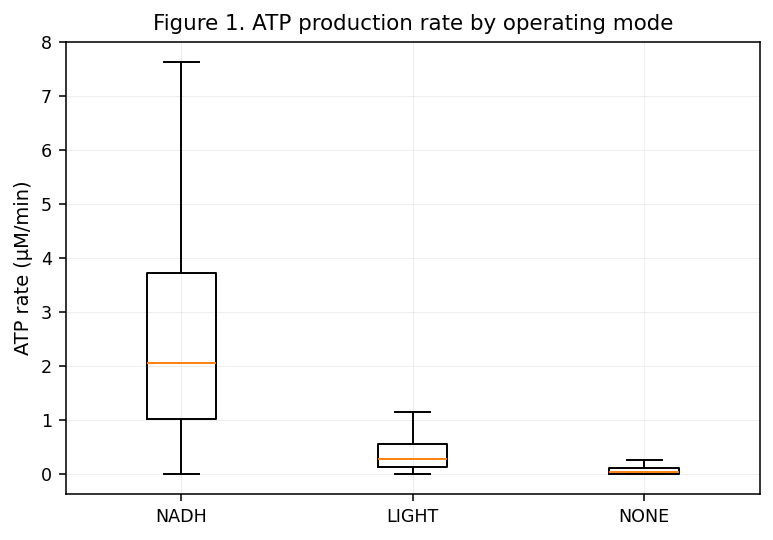

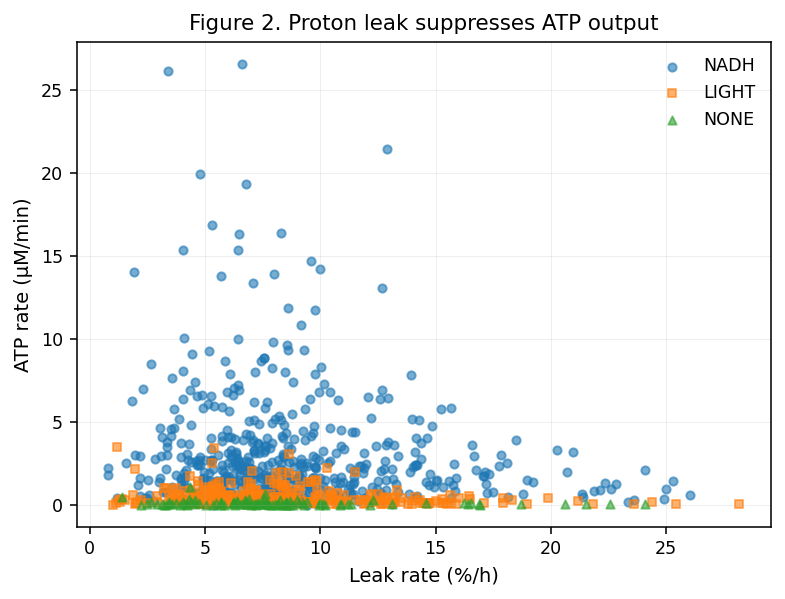

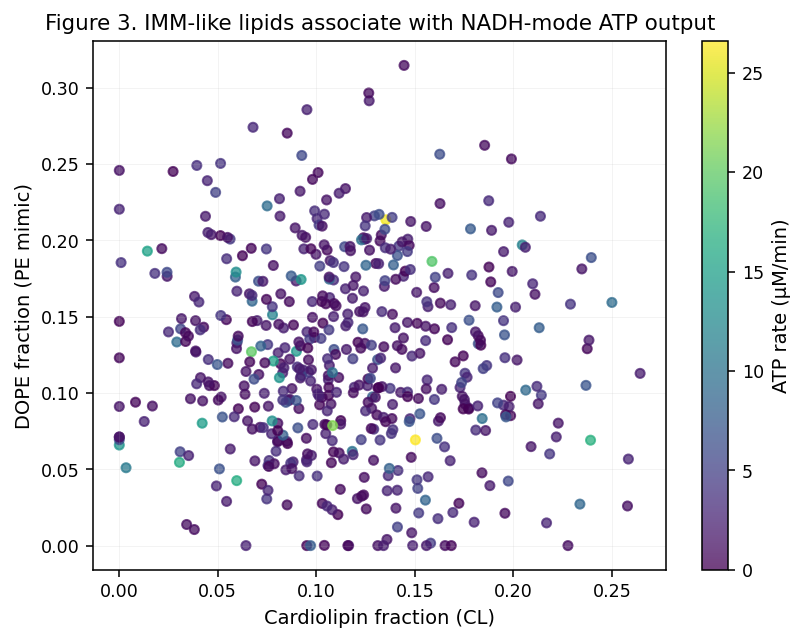

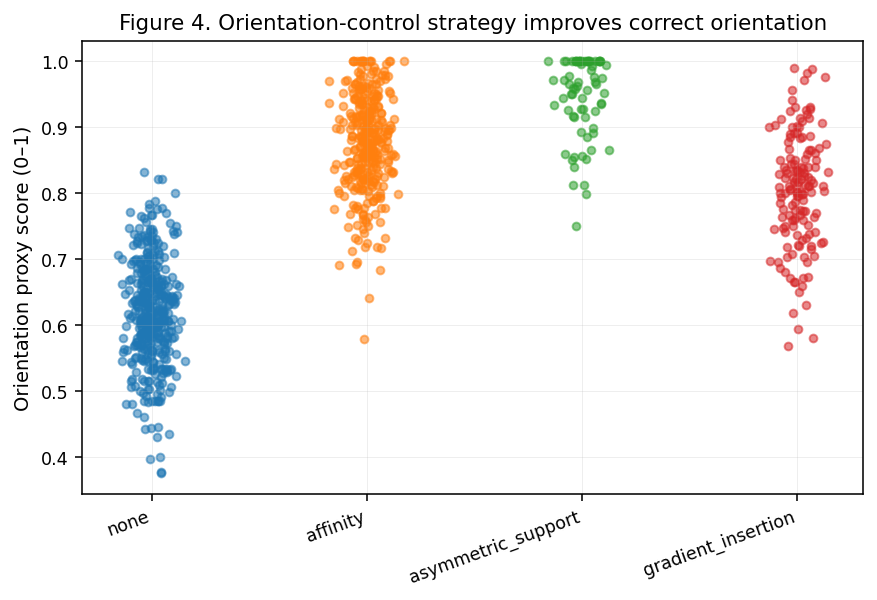

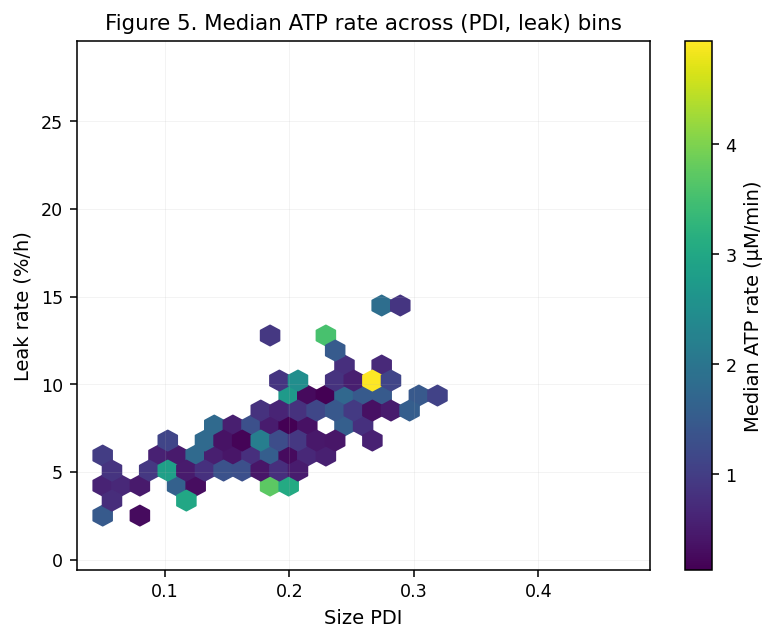

,proxy,R2,MAE
2,protein_incorporation_fraction,0.831868,0.054897
4,pmf_proxy_AU,0.770421,0.089303
3,orientation_proxy_score,0.762935,0.058351
5,on_off_ratio,0.650109,3.038878
0,size_pdi,-0.038497,0.070353
1,encapsulation_leak_rate_pct_per_h,-0.061113,3.407689


,metric,value
0,R2_design_time,0.735927
1,MAE_design_time_uM_per_min,0.697742


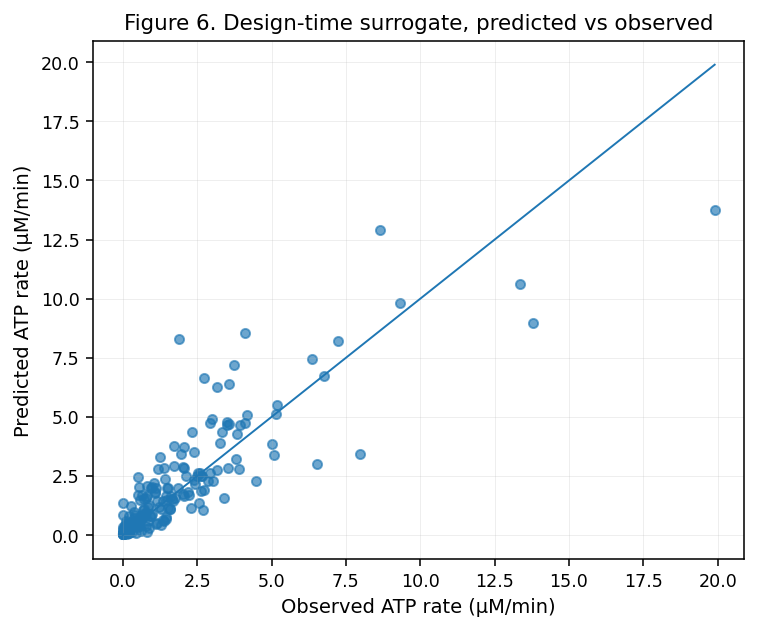

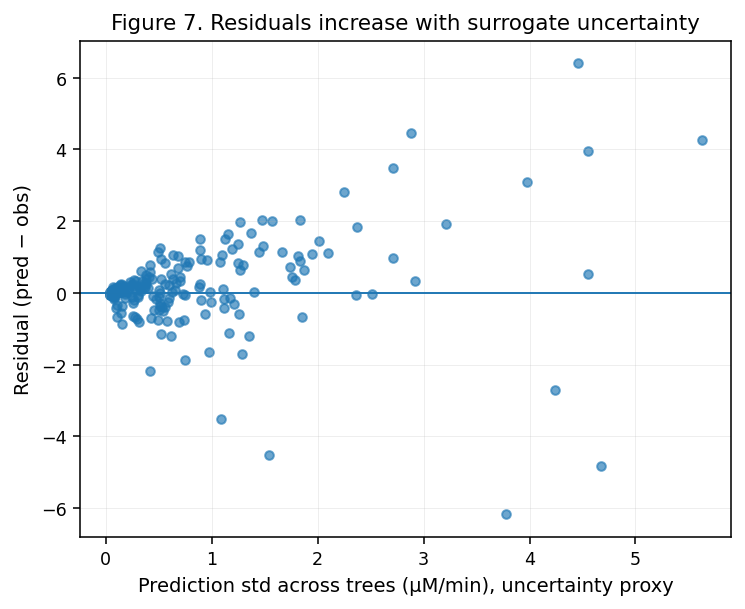

,feature,importance_mean,importance_std
7,atpsyn_to_lipid_ratio,0.883602,0.147145
23,pmf_proxy_AU,0.574682,0.162788
10,q10_nmol_mg_lipid,0.041336,0.028990
21,protein_incorporation_fraction,0.026188,0.007702
5,lipid_DOPC_frac,0.011361,0.003305
3,lipid_CL_frac,0.008049,0.007212
13,detergent_conc_mM,0.005271,0.002197
8,ci_to_atpsyn_molar_ratio,0.003026,0.010461
6,cholesterol_frac,0.001915,0.002393
1,platform,0.001144,0.001547


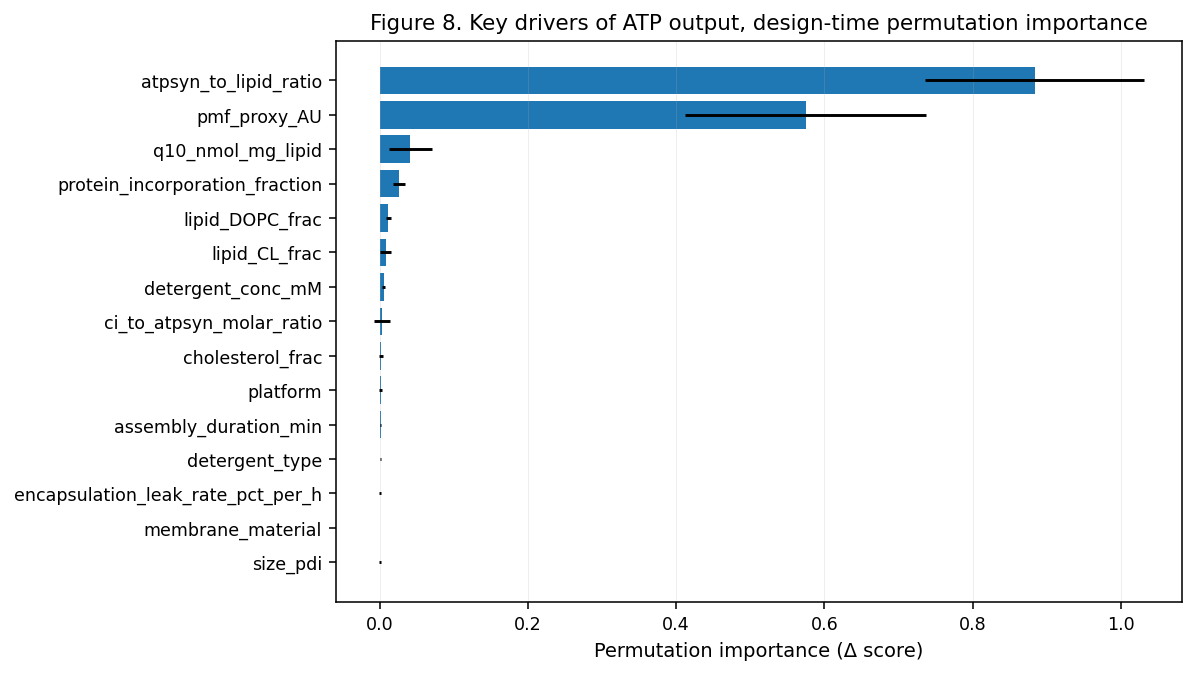

<Figure size 1148x812 with 0 Axes>

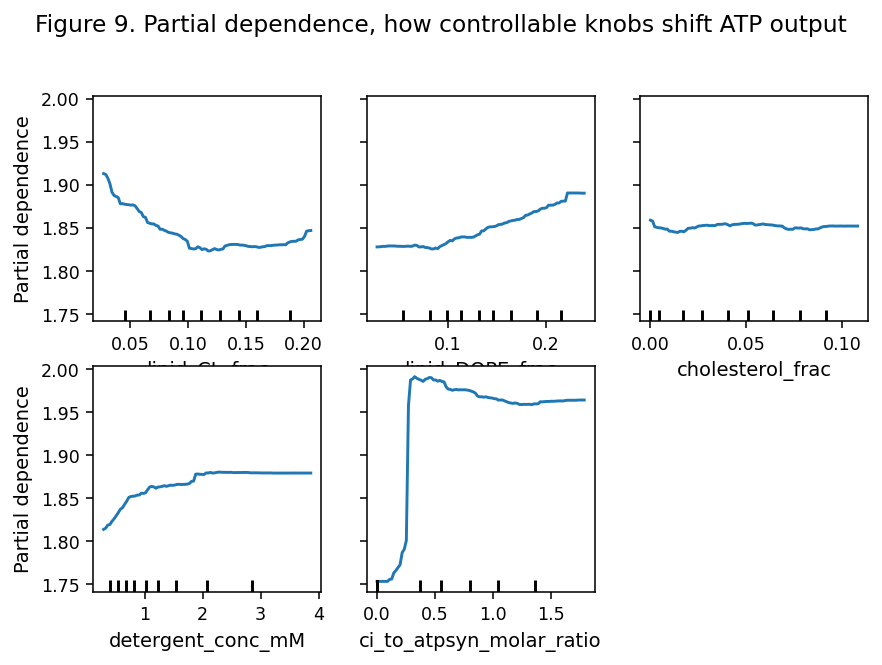

/var/folders/qh/fmzc9db1783cz_z1bj3znn44y1tlxj/T/ipykernel_12018/2763550241.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d.groupby(["mode","leak_bucket","pdi_bucket"])


,mode,leak_bucket,pdi_bucket,n,pass_rate,atp_median,storage_day9_median
0,LIGHT,"[0, 5)","[0.0, 0.15)",45,0.355556,0.278112,0.501822
1,LIGHT,"[0, 5)","[0.15, 0.25)",10,0.300000,0.521681,0.466372
2,LIGHT,"[0, 5)","[0.25, 0.35)",0,NaN,NaN,NaN
3,LIGHT,"[0, 5)","[0.35, 0.5)",0,NaN,NaN,NaN
4,LIGHT,"[0, 5)","[0.5, 1.0)",0,NaN,NaN,NaN
5,LIGHT,"[5, 10)","[0.0, 0.15)",46,0.347826,0.332305,0.480831
6,LIGHT,"[5, 10)","[0.15, 0.25)",108,0.324074,0.266728,0.463496
7,LIGHT,"[5, 10)","[0.25, 0.35)",39,0.384615,0.426517,0.457486
8,LIGHT,"[5, 10)","[0.35, 0.5)",0,NaN,NaN,NaN
9,LIGHT,"[5, 10)","[0.5, 1.0)",0,NaN,NaN,NaN


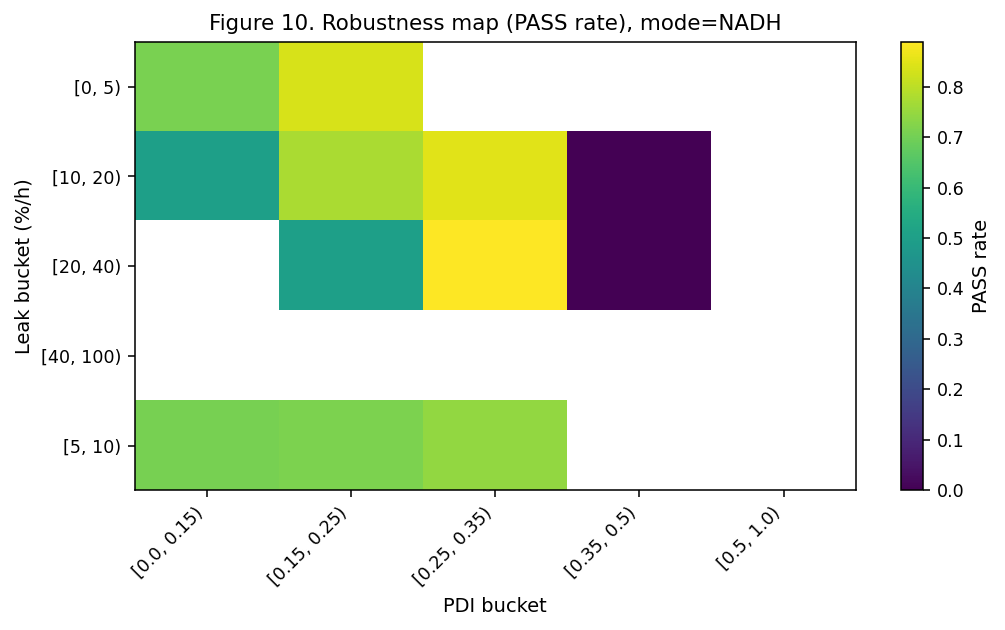

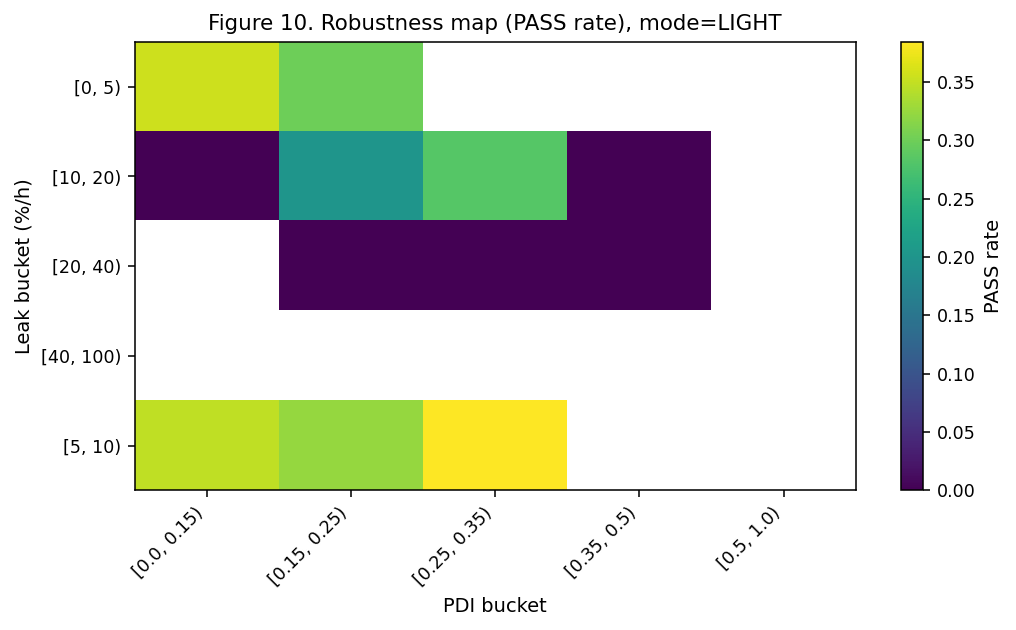

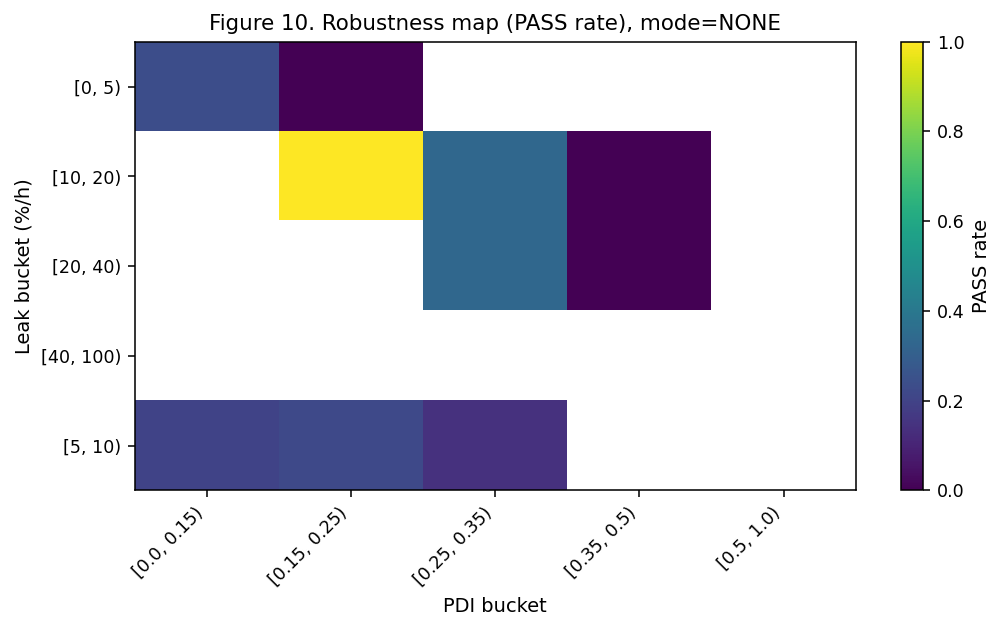

,mode,platform,membrane_material,lipid_CL_frac,lipid_DOPE_frac,lipid_DOPC_frac,cholesterol_frac,atpsyn_to_lipid_ratio,ci_to_atpsyn_molar_ratio,aox_to_ci_molar_ratio,...,orientation_method,size_pdi,encapsulation_leak_rate_pct_per_h,protein_incorporation_fraction,orientation_proxy_score,pmf_proxy_AU,on_off_ratio,pred_atp_rate_uM_per_min,pred_atp_rate_std,score
0,NADH,vesicle,lipid,0.041460,0.111333,0.847208,0.035204,0.019549,0.820700,0.357700,...,gradient_insertion,0.172637,7.709709,0.833174,0.833066,0.820089,21.553405,15.224619,3.327522,2.401808
1,NADH,vesicle,lipid,0.080556,0.103706,0.815737,0.035621,0.016820,0.687379,0.598063,...,affinity,0.164232,6.619512,0.845875,0.886699,0.792755,20.989744,14.822181,3.685226,2.156119
2,NADH,vesicle,lipid,0.056152,0.115745,0.828104,0.031287,0.023223,1.717214,0.704208,...,gradient_insertion,0.174089,7.548320,0.809542,0.835134,0.829247,22.842983,17.294942,4.553237,2.149812
3,NADH,vesicle,lipid,0.097279,0.100789,0.801932,0.027420,0.030000,1.020474,0.498686,...,asymmetric_support,0.172066,7.408268,0.847999,0.967720,0.930578,23.838558,17.394053,4.761459,1.944521
4,NADH,vesicle,polymersome,0.087516,0.124899,0.787584,0.049891,0.018644,0.734218,0.532851,...,affinity,0.153690,6.555347,0.773424,0.867947,0.819102,20.592202,14.791616,3.813188,1.920964
5,NADH,patch,lipid,0.080869,0.090369,0.828763,0.057706,0.024390,1.221445,0.418431,...,asymmetric_support,0.175977,7.887229,0.803874,0.947649,0.901446,22.338660,16.422155,4.105402,1.901567
6,NADH,vesicle,lipid,0.071480,0.078815,0.849705,0.024759,0.018760,0.883720,0.505640,...,affinity,0.182268,8.918966,0.843118,0.906679,0.943531,23.376256,15.572684,3.308589,1.820334
7,NADH,vesicle,lipid,0.096778,0.040000,0.863222,0.000000,0.021693,0.870838,1.272578,...,affinity,0.171014,7.974630,0.821916,0.909270,0.962284,24.035820,18.265291,5.053713,1.778160
8,NADH,vesicle,lipid,0.051355,0.140383,0.808261,0.040547,0.020261,1.071549,1.031718,...,affinity,0.161056,7.538183,0.767409,0.877339,0.946650,23.823538,15.932478,4.131454,1.639023
9,NADH,vesicle,lipid,0.071953,0.101448,0.826598,0.031739,0.023427,1.217254,0.854092,...,affinity,0.187056,7.867015,0.783599,0.887927,0.889431,22.843305,16.698586,4.399027,1.606920


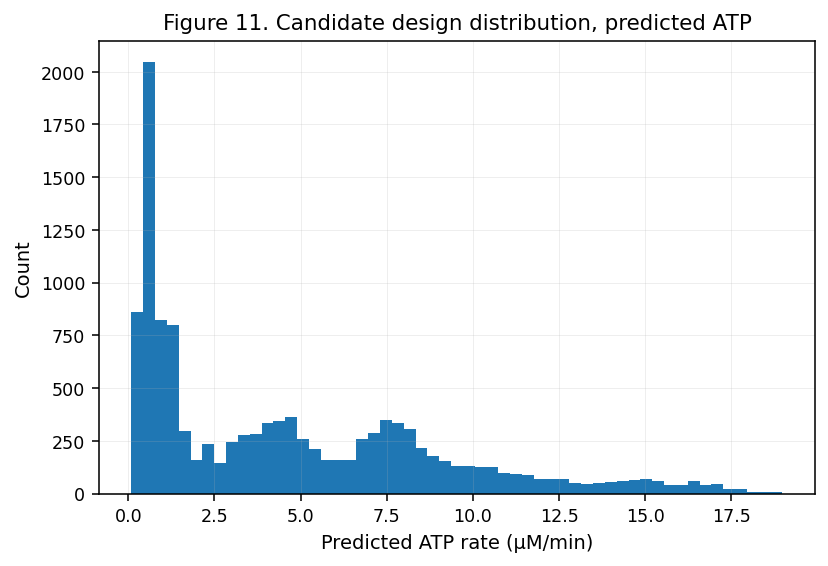

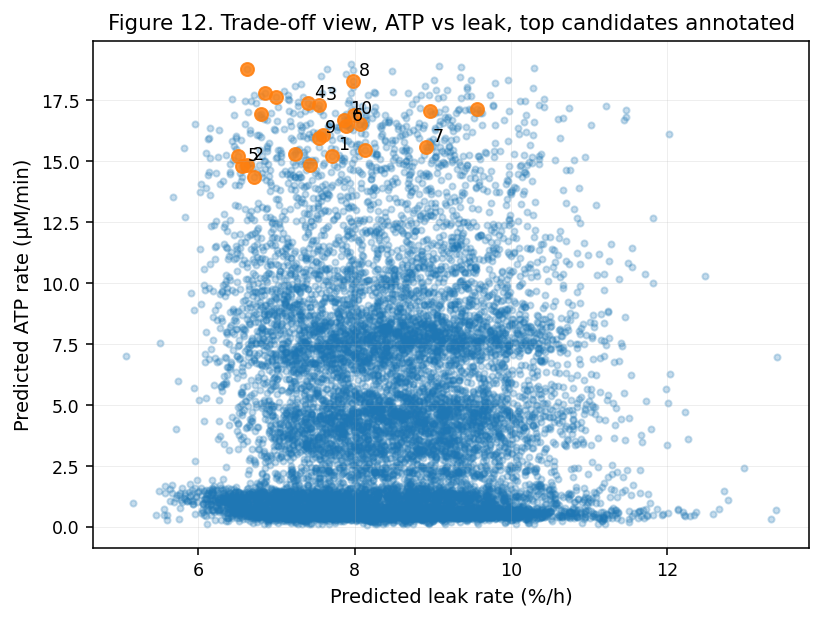

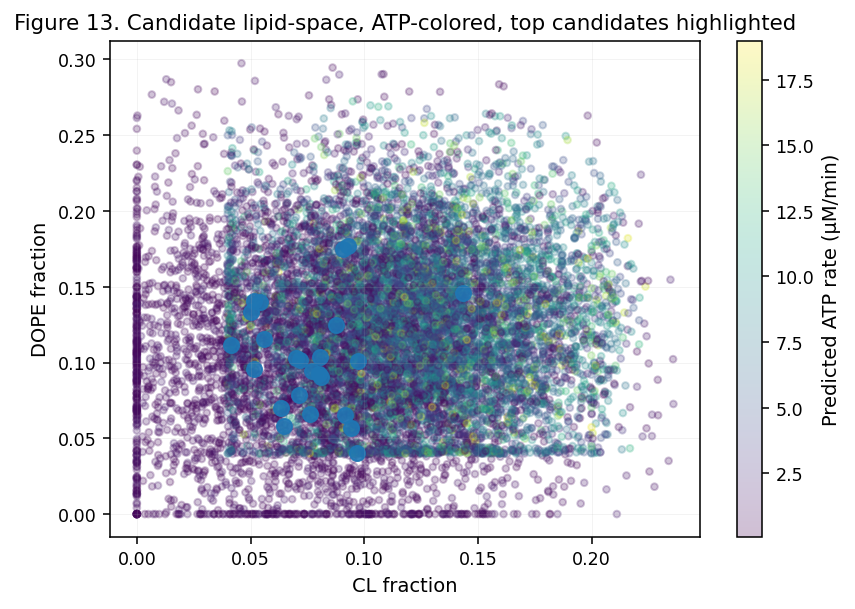

,mode,platform,membrane_material,lipid_CL_frac,lipid_DOPE_frac,lipid_DOPC_frac,cholesterol_frac,assembly_method,detergent_type,detergent_conc_mM,detergent_removal_method,orientation_method,atpsyn_to_lipid_ratio,ci_to_atpsyn_molar_ratio,aox_to_ci_molar_ratio,q10_nmol_mg_lipid,pred_atp_rate_uM_per_min,pred_atp_rate_std,encapsulation_leak_rate_pct_per_h,score
0,NADH,vesicle,lipid,0.041460,0.111333,0.847208,0.035204,detergent_removal,DDM,1.163089,biobeads,gradient_insertion,0.019549,0.820700,0.357700,8.528929,15.224619,3.327522,7.709709,2.401808
1,NADH,vesicle,lipid,0.080556,0.103706,0.815737,0.035621,detergent_removal,OG,0.934884,biobeads,affinity,0.016820,0.687379,0.598063,11.357279,14.822181,3.685226,6.619512,2.156119
2,NADH,vesicle,lipid,0.056152,0.115745,0.828104,0.031287,detergent_removal,DDM,0.840405,dialysis,gradient_insertion,0.023223,1.717214,0.704208,12.712755,17.294942,4.553237,7.548320,2.149812
3,NADH,vesicle,lipid,0.097279,0.100789,0.801932,0.027420,detergent_removal,OG,0.945322,dialysis,asymmetric_support,0.030000,1.020474,0.498686,13.149859,17.394053,4.761459,7.408268,1.944521
4,NADH,vesicle,polymersome,0.087516,0.124899,0.787584,0.049891,microfluidic_mix,DDM,0.861143,biobeads,affinity,0.018644,0.734218,0.532851,11.145754,14.791616,3.813188,6.555347,1.920964
5,NADH,patch,lipid,0.080869,0.090369,0.828763,0.057706,detergent_removal,DDM,0.809239,biobeads,asymmetric_support,0.024390,1.221445,0.418431,12.055351,16.422155,4.105402,7.887229,1.901567
6,NADH,vesicle,lipid,0.071480,0.078815,0.849705,0.024759,detergent_removal,DDM,1.498107,biobeads,affinity,0.018760,0.883720,0.505640,12.461076,15.572684,3.308589,8.918966,1.820334
7,NADH,vesicle,lipid,0.096778,0.040000,0.863222,0.000000,microfluidic_mix,OG,1.174933,biobeads,affinity,0.021693,0.870838,1.272578,18.332619,18.265291,5.053713,7.974630,1.778160
8,NADH,vesicle,lipid,0.051355,0.140383,0.808261,0.040547,microfluidic_mix,DDM,0.778269,biobeads,affinity,0.020261,1.071549,1.031718,17.195760,15.932478,4.131454,7.538183,1.639023
9,NADH,vesicle,lipid,0.071953,0.101448,0.826598,0.031739,detergent_removal,OG,0.529106,biobeads,affinity,0.023427,1.217254,0.854092,16.405219,16.698586,4.399027,7.867015,1.606920


In [58]:
df = simulate_dataset(n_builds=950)

print("Dataset shape:", df.shape)
display(df.head(5))

summary = summarize_by_mode(df)
display(summary)

tops = top_designs(df, k=15)
display(tops)

exploratory_figures(df)

design_predictor = build_design_time_predictor(df)

interpretability(design_predictor, df)

rob = robustness_matrix(df)

top_next = propose_next_builds(design_predictor, n_candidates=12000, top_k=24)

# Quick "human-readable" shortlist, focusing on knobs we can actually set

cols_short = [
    "mode","platform","membrane_material",
    "lipid_CL_frac","lipid_DOPE_frac","lipid_DOPC_frac","cholesterol_frac",
    "assembly_method","detergent_type","detergent_conc_mM","detergent_removal_method",
    "orientation_method",
    "atpsyn_to_lipid_ratio","ci_to_atpsyn_molar_ratio","aox_to_ci_molar_ratio","q10_nmol_mg_lipid",
    "pred_atp_rate_uM_per_min","pred_atp_rate_std","encapsulation_leak_rate_pct_per_h","score"
]
display(top_next[cols_short].head(12))


# Explanation:
 - Each row is one "build" of a synthetic inner-mitochondrial-membrane-like energy module.
 - Choice of controllable knobs: lipids (CL/DOPE/DOPC), detergent & removal method, temperature/mixing, orienting the proteins, and the CI:ATP-synthase:AOX:Q10 ratios.
 - The simulator generates what can be measured after the build:
   how leaky it is, whether proteins inserted and face the right way, a "pmf proxy", and then ATP output.
 - ML learns two things:
   (1) how build choices tend to produce (or ruin) good membranes (leak, orientation, incorporation),
   (2) how those translate into ATP output.
 - propose_next_builds then explores thousands of new designs and picks the best “high ATP, low leak,
   low uncertainty” candidates, with clear plots to guide what to try next.